# GNSS Download and Processing

In this exercise you will learn the following:

- authenticate to the GAGE file server
- discover data
- read RINEX files with georinex
- process data 
- plot the results

The following code block sets up the program by importing modules.

In [6]:
import time
from datetime import datetime, timedelta
import numpy as np
import os, json

import matplotlib.pyplot as plt

import requests
from pathlib import Path
 
from earthscope_sdk.auth.device_code_flow import DeviceCodeFlowSimple
from earthscope_sdk.auth.auth_flow import NoTokensError


The GAGE file server requires authentication. We create two functions, one to perform the authentication and another to retrieve a file.

In [7]:
def get_token(token_path='./'):
  """function to get earthscope data using es-sdk
    modified from https://gitlab.com/earthscope/public/earthscope-sdk

    Parameters
    ----------
    url : string
        url of desired file at gage-data.earthscope.org
    directory_to_save_file : str, optional
        path of directory in which to save the file, by default cwd
    token_path : str, optional
        path of directory in which to save the token, by default './'
    """
  # instantiate the device code flow subclass
  device_flow = DeviceCodeFlowSimple(Path(token_path))
  try:
    # get access token from local path
    device_flow.get_access_token_refresh_if_necessary()
  except NoTokensError:
    # if no token was found locally, do the device code flow
    device_flow.do_flow()
  token = device_flow.access_token

  return token

def get_es_file(url, directory_to_save_file='./', token_path='./'):

  # get authorization Bearer token
  token = get_token()

  # request a file and provide the token in the Authorization header
  file_name = Path(url).name

  r = requests.get(url, headers={"authorization": f"Bearer {token}"})
  if r.status_code == requests.codes.ok:
    # save the file
    with open(Path(Path(directory_to_save_file) / file_name), 'wb') as f:
        for data in r:
            f.write(data)
  else:
    #problem occured
    print(f"failure: {r.status_code}, {r.reason}")

***Stretch Goal***
If files are downloaded in parallel, it can reduce the time for the program to complete. Can you create a new function that implements a parallel download? Look at this [solution](https://opensourceoptions.com/use-python-to-download-multiple-files-or-urls-in-parallel/) from OpenSource Options. Add a code cell below with your code.

In [8]:
# Parallel download

from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

## add your code

## Finding Data Programatically with Python

You can find data for a location by using EarthScope's API and the [GNSS Station Radial Search](https://api.earthscope.org/beta/docs#get-/discover/gnss/radial) interface. If we're looking for a station near Portales, New Mexico we can use the coordinates for Portales to find stations. We can use the web interface to find stations.

![](../../images/gnss_radial_search.png)

The web interface can show the curl request and we can use that to build a request in Python.

>curl -X GET "https://api.earthscope.org/beta/discover/gnss/radial?latitude=34.147255&longitude=-103.4073&distance=50&tier=station&facility=earthscope&with_information=true" \
 -H 'accept: application/json'\
-H 'authorization: Bearer aaaabbbbbccccc


In [9]:
# complete this code block by getting the bearer token

base_url = "https://api.earthscope.org/beta/discover/gnss/radial?"

latitude = 34.147255
longitude=-103.4073
distance=50
tier="station"
facility="earthscope"
with_information="true"

params = "latitude={}&longitude={}&distance={}&tier={}&facility={}&with_information={}".format(latitude, longitude, distance, tier, facility, with_information)

url = base_url+params

token = get_token()

response = requests.get(url, headers={"authorization": f"Bearer {token}"})

The api returns the response in JSON. Parse the JSON to get the station name.

In [10]:
data = response.json()
json_formatted = json.dumps(data, indent=2)
print(json_formatted)


[
  {
    "edid": "01H46MTKV0S5RVXJVG9GG7EQAE",
    "pnum": "PNUM:P038",
    "igs": "IGS:P03800USA",
    "lat": 34.14725482,
    "lon": -103.4073405,
    "elev": 1213.01009
  }
]


In [11]:
# get the station name(s) from 'pnum' key
value = data[0]['pnum']
station = value.split(':')[1].lower()
print(station)

p038


With the station identifier, we can generate the urls to download the data. The url for downloading GNSS RINEX observatio data takes this form

```
https://gage-data.earthscope.org/archive/gnss/rinex/obs/<year>/<day>/<station><day>0.<two digit year>d.Z
```

https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/001/p0380010.25d.Z

**NOTE:**

- `day` is zero padded
- `d.Z` is for Hatakana compressed file with 

Write a function to download daily data from a station and get the mean SNR value for each day. To do this, we will use [georinex](https://github.com/geospace-code/georinex/tree/main), a package for reading and processing RINEX files.

In [12]:
# install georinex  
%pip install georinex

Note: you may need to restart the kernel to use updated packages.


First, we'll instantiate lists to hold values for download time and the time to process a file. Two arrays to hold the mean SNR values and the dates are created. Finally, we'll set the year of interest.

In [13]:
# a list to hold the time to download a file
dl_time=[]

# a list to hold the time to process a file
pr_time=[]

# lists to hold SNR values and the date for each value
snr_list=[]
date_list=[]

# year and starting day to download
year=2025
day = 1


The `download_process` function downloads the first 10 days of RINEX files for the year. The files are written to the `rinex` directory which must be present.

Georinex reads RINEX observation data in [xarray](https://docs.xarray.dev/en/stable/index.html#) which makes it simple to extract data from multi-dimensional arrays using labels.

```python
obs = gr.load(fn, use='G', meas=['S1'])
```

[![](../../images/satellite_identifier.png)](https://files.igs.org/pub/data/format/rinex305.pdf)

[![](../../images/rinex_2char_code.png)](https://www.ngs.noaa.gov/CORS/RINEX211.txt)

The statement above reads the file (`fn`), and extracts the L1 data (`meas=['S1']`) from GPS data (`use='G'`). The mean is calculated for all observations for the day and added to `snr_list`.

```python
g=obs['S1'].mean().values
snr_li+=[g]
```

In [14]:
import georinex as gr #https://github.com/geospace-code/georinex/blob/main/Readme_OBS.md

def download_process(doy, year, station, snr_list, date_list):
    two_digit_year=str(year)[2:] #converts integer to string and slices the last characters
    for doy in np.arange(1,10):
        #download
        url='https://gage-data.earthscope.org/archive/gnss/rinex/obs/%d/%03d/%s%03d0.%sd.Z' %(year,doy,station,doy,two_digit_year)
        print('downloading: ', url)
        get_es_file(url, 'rinex_data')
        
        #process
        fn='rinex_data/%s%03d0.%sd.Z' %(station, doy, two_digit_year)
        # Use Georinex to convert Rinex _> Xarray Dataframe
        obs = gr.load(fn, use='G', meas=['S1'])
        g=obs['S1'].mean().values
        snr_list+=[g]
        date_list+=[datetime(year, 1, 1) + timedelta(days=int(doy - 1))]
        #delete the file
        os.remove(fn)
        

Call the `download_process` function and plot the results. Note that `snr_list` and `date_list` are passed as arguments because the function doesn't have access to them in it's scope.

In [15]:
start_t = time.time()
download_process(day, year, station, snr_list, date_list)
end_t = time.time()
dl_time=end_t-start_t

snr_rnx=np.mean(snr_list)

downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/001/p0380010.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/002/p0380020.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/003/p0380030.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/004/p0380040.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/005/p0380050.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/006/p0380060.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/007/p0380070.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/008/p0380080.25d.Z
downloading:  https://gage-data.earthscope.org/archive/gnss/rinex/obs/2025/009/p0380090.25d.Z


Plot the results.

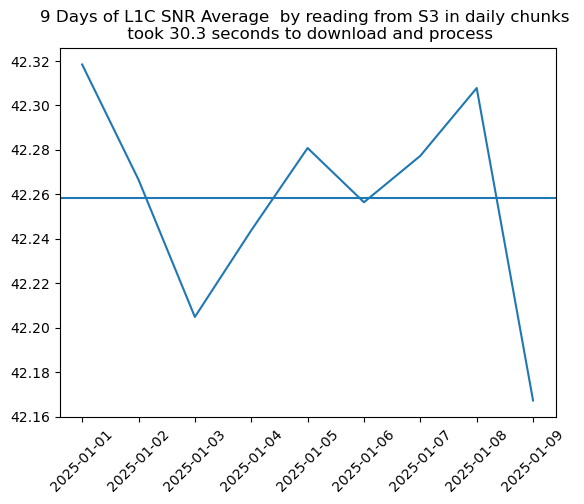

In [16]:
# Plot results ##########
plt.plot(date_list, snr_list)
plt.xticks(rotation=45)
plt.axhline(snr_rnx)
plt.title('%s Days of L1C SNR Average  by reading from S3 in daily chunks \n took %.1f seconds to download and process' %(len(date_list),dl_time))
plt.show()

It's good practice to remove authentication tokens when you are finished.

In [17]:
token_fn = "./sso_tokens.json"
os.remove(token_fn)